# **Film recommendation engine**
*Gonzalo Izaguirre (diciembre 2019)*
___

El objetivo de este notebook es crear un motor de recomendación a partir del contenido del fichero `movie_metadata.csv`.Este dataset contiene alrededor de 5000 películas y series, y su descripción ha sido recogida de la base de datos de IMDB. Basicamente, el sistema funcionará de la siguiente forma: después de que el usuario haya introducido el nombre de una película que le haya gustado, el sistema seleccionará del conjunto total 5 películas que agradarán al usuario al ser similares.
This dataset contains around 5000 movies and TV series, and their description has been retrieved from the public IMDB database. Existen tres tipos de filtros colaborativos:
- Sistemas **popularity-based**: los más simples de implementar, aunque los más impersonales
- Sistemas **content-based**: La recomendación se basa en la descripción del producto
- Sistemas **collaborative filtering**: datos de diferentes usuarios dan recomendaciones basadas en similaridades entre usuarios.

In the current case, since the dataset only describe the content of the films and TV series, collaborative filtering is excluded and I will thus build an engine that uses both the content and the popularity of the entries.

En este caso, dado que el conjunto de datos solo describe el contenido de las películas, no puede aplicarse el filtrado colaborativo. Se creará un motor que usará tanto el contenido como la popularidad de las entradas.
___
El notebook se organiza de la siguiente manera:

**1. Exploración**
- 1.1 Keywords
- 1.2 Factor de completitud: Valores Faltantes
- 1.3 Películas por año
- 1.4 Géneros

**2. Limpieza**
- 2.1 Entradas duplicadas
- 2.2 Limpieza de keywords
    * 2.2.1 Agrupamiento por lexema
    * 2.2.2 Agrupamiento por sinónimos
- 2.3 Correlaciones
- 2.4 Valores faltantes
    * 2.4.1 Años faltantes
    * 2.4.2 Extrayendo keywords del título
    * 2.4.3 Completado de datos mediante regresión
    
**3. Recommendation Engine**
- 3.1 Funcionamiento básico del motor 
    * 3.1.1 Similaridad
    * 3.1.2 Popularidad
- 3.2 Definicion de las funciones del motor de recomendación
- 3.3 Realizando recomendaciones interesantes
- 3.4 Ejemplo de recomendación

**4. Conclusión: posibles mejoras y puntos a concretar**



___
## 1. Exploración

 Se cargan todos los paquetes y el conjunto de datos. Se da información sobre los tipos de las columnas y los datos faltantes.

In [1]:
import json
import pandas as pd

In [2]:

def load_tmdb_movies(path):
    """Función utilizada para cargar el dataset de las películas. Se transforma a fecha el campo de fecha de salida
    y se cargan como listas los campos que están guardados como json.
    
    Args:
        path (str): Ruta hasta el archivo de tmdb_5000_movies.csv
    
    Returns:
        pd.DataFrame: Dataframe de pandas con la información del csv
    """
    df = pd.read_csv(path)
    df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.date())
    json_columns = ['genres', 'keywords', 'production_countries', 'production_companies', 'spoken_languages']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df


def load_tmdb_credits(path):
    """Función utilizada para cargar el dataset de los créditos. Se cargan como listas los campos que están guardado
    
    Args:
        path (str): Ruta hasta el archivo de tmdb_5000_credits.csv

    Returns:
        pd.DataFrame: [description]
    """
    df = pd.read_csv(path)
    json_columns = ['cast', 'crew']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df

In [3]:
TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES = {
    'budget': 'budget',
    'genres': 'genres',
    'revenue': 'gross',
    'title': 'movie_title',
    'runtime': 'duration',
    'original_language': 'language',  # it's possible that spoken_languages would be a better match
    'keywords': 'plot_keywords',
    'vote_count': 'num_voted_users',
                                         }

IMDB_COLUMNS_TO_REMAP = {'imdb_score': 'vote_average'}

In [4]:
%config IPCompleter.greedy=True

In [5]:
def safe_access(container, index_values):
    """Función para acceder de forma segura a valores. En caso de que no se encuentre uno de ellos, se devuelve NaN
    en vez de lanzar un error.
    
    Args:
        container (list): Lista/ contenedor de la que quieren extraerse los valores
        index_values (list): Lista de índices a extraer del contenedor
    
    Returns:
        any: Valores extraidos
    """
    result = container
    try:
        for idx in index_values:
            result = result[idx]
        return result
    except IndexError or KeyError:
        return pd.np.nan


def get_director(crew_data):
    """Devuelve el director dado un json con toda la composición del equipo de la película.
    
    Args:
        crew_data (json): JSON con el equipo que ha realizado la película
    
    Returns:
        str: Director de la película
    """
    directors = [x['name'] for x in crew_data if x['job'] == 'Director']
    return safe_access(directors, [0])


def pipe_flatten_names(keywords):
    """Obtiene una lista con las keywords separadas por un pipe | extrayéndolas del json.
    
    Args:
        keywords (json): keywords de la película
    
    Returns:
        str: keywords de la película juntas
    """
    return '|'.join([x['name'] for x in keywords])


def convert_to_original_format(movies, credits):
    """Aplica una serie de funciones para añadir información al dataset de películas a partir del
    conjunto de datos de créditos
    
    Args:
        movies (pd.DataFrame): DataFrame obtenido de leer el archivo de películas
        credits (pd.DataFrame): DataFrame obtenido de leet el archivo de créditos
    
    Returns:
        pd.DataFrame: DataFrame con la información conjunta
    """
    tmdb_movies = movies.copy()
    tmdb_movies.rename(columns=TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES, inplace=True)
    tmdb_movies['title_year'] = pd.to_datetime(tmdb_movies['release_date']).apply(lambda x: x.year)
    # I'm assuming that the first production country is equivalent, but have not been able to validate this
    tmdb_movies['country'] = tmdb_movies['production_countries'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['language'] = tmdb_movies['spoken_languages'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['director_name'] = credits['crew'].apply(get_director)
    tmdb_movies['actor_1_name'] = credits['cast'].apply(lambda x: safe_access(x, [1, 'name']))
    tmdb_movies['actor_2_name'] = credits['cast'].apply(lambda x: safe_access(x, [2, 'name']))
    tmdb_movies['actor_3_name'] = credits['cast'].apply(lambda x: safe_access(x, [3, 'name']))
    tmdb_movies['genres'] = tmdb_movies['genres'].apply(pipe_flatten_names)
    tmdb_movies['plot_keywords'] = tmdb_movies['plot_keywords'].apply(pipe_flatten_names)
    return tmdb_movies

In [6]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math, nltk, warnings
from nltk.corpus import wordnet
from sklearn import linear_model
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import fuzz
from wordcloud import WordCloud, STOPWORDS
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings('ignore')

#Definimos la función a utilizar para obtener el lexema de las palabras.
PS = nltk.stem.PorterStemmer()
#__________________
# load the dataset
#df_initial = pd.read_csv("../input/movie_metadata.csv")
credits = load_tmdb_credits("./datos/tmdb_5000_credits.csv")
movies = load_tmdb_movies("./datos/tmdb_5000_movies.csv")
df_initial = convert_to_original_format(movies, credits)
print('Shape:',df_initial.shape)
#__________________________________________
# Información sobre los tipos de variable y el factor de completitud
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
tab_info

Shape: (4803, 26)


,budget,genres,homepage,id,plot_keywords,language,original_title,overview,popularity,production_companies,production_countries,release_date,gross,duration,spoken_languages,status,tagline,movie_title,vote_average,num_voted_users,title_year,country,director_name,actor_1_name,actor_2_name,actor_3_name
column type,int64,object,object,int64,object,object,object,object,float64,object,object,object,int64,float64,object,object,object,object,float64,int64,float64,object,object,object,object,object
null values,0,0,3091,0,0,86,0,3,0,0,0,1,0,2,0,0,844,0,0,0,1,174,30,53,63,93
null values (%),0,0,64.3556,0,0,1.79055,0,0.062461,0,0,0,0.0208203,0,0.0416406,0,0,17.5724,0,0,0,0.0208203,3.62274,0.62461,1.10348,1.31168,1.93629


In [109]:
print(tab_info.to_latex())

\begin{tabular}{lllllllllllllllllllllllllll}
\toprule
{} & budget &  genres & homepage &     id & plot\_keywords & language & original\_title &  overview & popularity & production\_companies & production\_countries & release\_date &  gross &   duration & spoken\_languages &  status &  tagline & movie\_title & vote\_average & num\_voted\_users & title\_year &  country & director\_name & actor\_1\_name & actor\_2\_name & actor\_3\_name \\
\midrule
column type     &  int64 &  object &   object &  int64 &        object &   object &         object &    object &    float64 &               object &               object &       object &  int64 &    float64 &           object &  object &   object &      object &      float64 &           int64 &    float64 &   object &        object &       object &       object &       object \\
null values     &      0 &       0 &     3091 &      0 &             0 &       86 &              0 &         3 &          0 &                    0 &                    

___
### 1.1 Keywords

Para desarrollar el sistema de recomendación, se hará un uso extensivo de las palabras clave que describen las películas. De hecho, una asunción básica en el proyecto es que las películas descritas por keywords similares deberían tener contenido similar. Por tanto, se realizará un analisis de cómo están definidas las keywords en un primer paso. En primer lugar, veamos las keywords que hay en el conjunto de datos.

In [7]:
set_keywords = set()
for liste_keywords in df_initial['plot_keywords'].str.split('|').values:
    if isinstance(liste_keywords, float): continue  # Evitar las películas en las que no hay keywords
    set_keywords = set_keywords.union(liste_keywords)

and then define a function that counts the number of times each of them appear:

In [8]:
def count_word(df, ref_col, lista):
    """Toma una columna de un dataframe y un set de valores y devuelve un diccionario y una lista
    con el numero de apariciones de cada elemento de la lista en la columna del dataframe

    Args:
        df (pd.DataFrame]): DataFrame del que extraer la información
        ref_col (str): Columna de la que extraer los valores diferentes
        lista (list): Lista con los diferentes valores de los que extraer sus apariciones
    Returns:
        list: Número de apariciones
        dict: Número de apariciones

    """
    keyword_count = dict()
    for s in lista: keyword_count[s] = 0
    for lista_keywords in df[ref_col].str.split('|'):
        if type(lista_keywords) == float and pd.isnull(lista_keywords): continue
        #for s in lista:
        for s in [s for s in lista_keywords if s in lista]:
            if pd.notnull(s): keyword_count[s] += 1
    #______________________________________________________________________
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

Esta función se usará de nuevo en otras secciones del notebook, cuando se explore el contenido de la variable `generos` y, obviamente, cuando limpiemos las keywords. Finalmente, llamando a esta funcion tenemos acceso a la lista de kweywords que están ordenadas en orden decreciente por número de apariciones.

In [9]:
# Diferentes keywords y número de apariciones
keyword_occurences, _ = count_word(df_initial, 'plot_keywords', set_keywords)
keyword_occurences[:5]

[['', 412],
 ['woman director', 324],
 ['independent film', 318],
 ['duringcreditsstinger', 307],
 ['based on novel', 197]]

In [10]:
# Se retiran las keywords que son vacías
keyword_occurences = [x for x in keyword_occurences if x[0]]
keyword_occurences[:5]

[['woman director', 324],
 ['independent film', 318],
 ['duringcreditsstinger', 307],
 ['based on novel', 197],
 ['murder', 189]]

En este momento, la lista de palabras ha sido creada y sabemos el número de veces que aparece cada una en el set de datos. De hecho, esta lista puede usarse para tener cierta intuicion del contenido de las películas más populares. Una forma interesante de dar esta información hace uso del paquete *wordcloud*. En este tipo de representación, todas las palabras se sitúan en la figura con tamaños que dependen de su frecuencia. En vez de una nube de palabras, se pueden usar histogramas. Esto permite tener una figura en la que las keywords están ordenadas por frecuencia de aparición y nos da la posibilidad de conocer la frecuencia exacta de cada palabra, tarea que no puede realizarse viendo únicamente la nube de palabras.

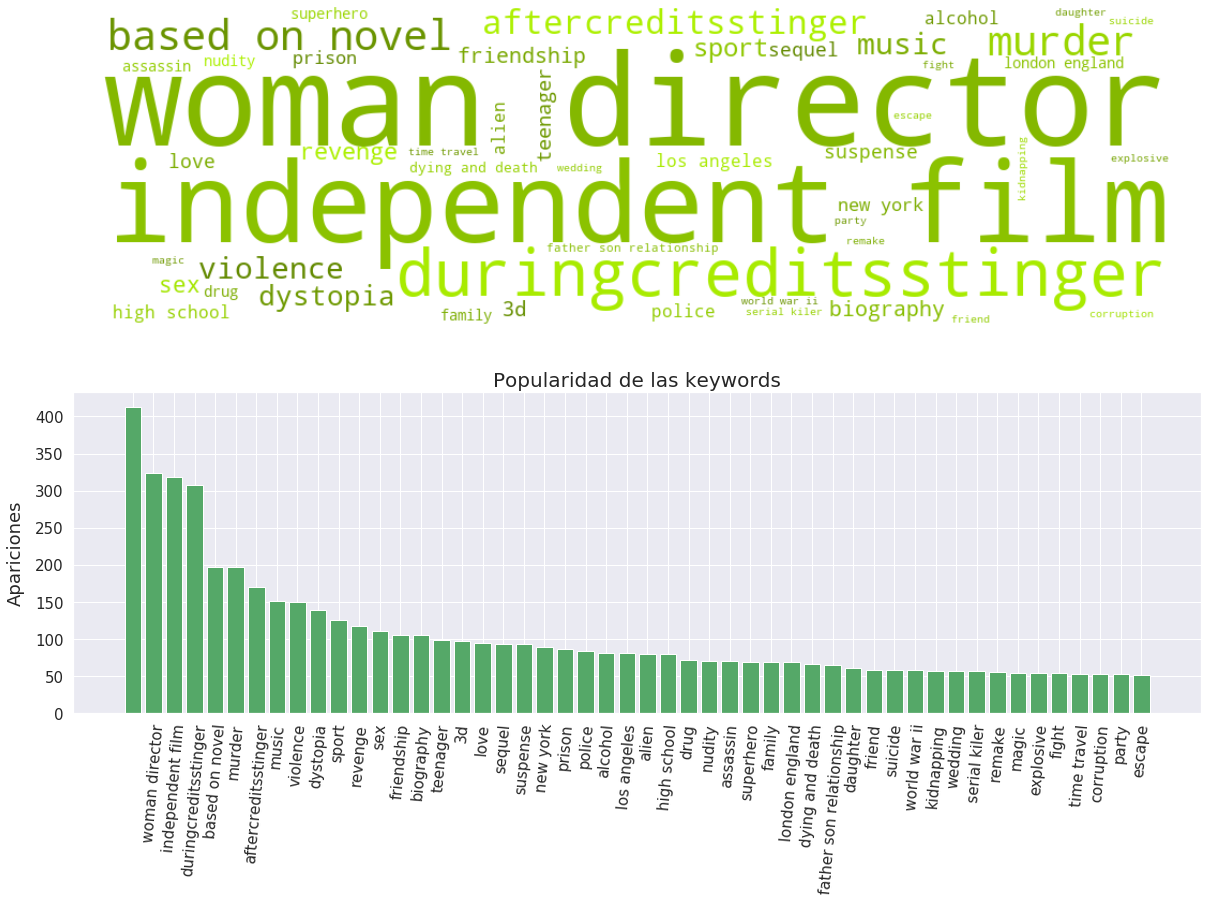

In [111]:
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)
#_____________________________________________
# Nube de palabras
fig = plt.figure(1, figsize=(18,13))
ax1 = fig.add_subplot(2,1,1)
#_______________________________________________________
# Diccionario usado para generar la imagen
words = dict()
trunc_occurences = keyword_occurences[0:50]
for s in trunc_occurences:
    words[s[0]] = s[1]
tone = 55.0 # define the color of the words
#________________________________________________________
wordcloud = WordCloud(width=1000,height=300, background_color='white', 
                      max_words=1628,relative_scaling=1,
                      color_func = random_color_func,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
ax1.imshow(wordcloud, interpolation="bilinear")
ax1.axis('off')
#_____________________________________________
# Histograma
ax2 = fig.add_subplot(2,1,2)
y_axis = [i[1] for i in trunc_occurences]
x_axis = [k for k,i in enumerate(trunc_occurences)]
x_label = [i[0] for i in trunc_occurences]
plt.xticks(rotation=85, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(x_axis, x_label)
plt.ylabel("Apariciones", fontsize = 18, labelpad = 10)
ax2.bar(x_axis, y_axis, align = 'center', color='g')
#_______________________
plt.title("Popularidad de las keywords",fontsize = 20)
plt.show()

___
### 1.2 Factor de completitud: Valores Faltantes

El conjunto de datos consiste en 5043 películas o series que están descritas mediante 28 variables. Como en todo análisis, habrá que trater con los valores faltantes y, como un primer paso, se calcula la cantidad de datos faltantes en cada variable:

In [12]:
missing_df = df_initial.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['filling_factor'] = (df_initial.shape[0] 
                                - missing_df['missing_count']) / df_initial.shape[0] * 100
missing_df.sort_values('filling_factor').reset_index(drop = True)


,column_name,missing_count,filling_factor
0,homepage,3091,35.644389
1,tagline,844,82.427649
2,country,174,96.377264
3,actor_3_name,93,98.063710
4,language,86,98.209452
5,actor_2_name,63,98.688320
6,actor_1_name,53,98.896523
7,director_name,30,99.375390
8,overview,3,99.937539
9,duration,2,99.958359


Podemos ver que la integridad de los datos es bastante buena, ya que únicamente 2 de las 28 variables tienen un factor de competitud menor del 93%.

___
### 1.3 Películas por año

La variable **title_year** indica cuándo se lanzó una película. Para tener una visión global de la forma en la que las películas se distribuyen según esta variable, las agrupamos por décadas:

In [13]:
#Obtenemos la década de cada película

df_initial['decade'] = df_initial['title_year'].apply(lambda x:((x-1900)//10)*10)
def get_stats(gr):
    """Devuelve las estadísticas de un DataFrame agrupado
    
    Arguments:
        gr -- DataFrame agrupado
    
    Returns:
        dict -- Diccionario que contiene las estadísticas principales de cada grupo
    """
    return {'min':gr.min(),'max':gr.max(),'count': gr.count(),'mean':gr.mean()}#______________________________________________________________
# Creación de un DataFrame con información estadística de cada década
test = df_initial['title_year'].groupby(df_initial['decade']).apply(get_stats).unstack()

y representamos los resultados en un diagrama de sectores

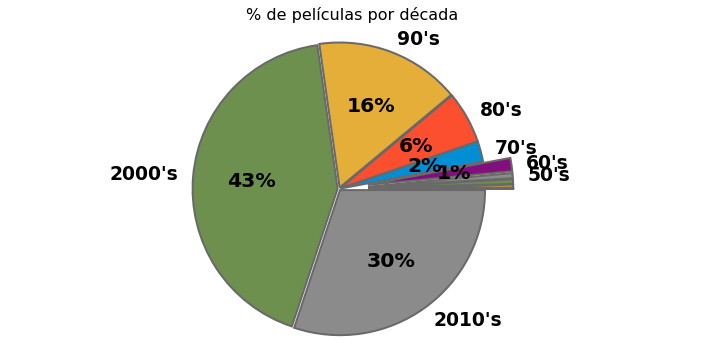

In [14]:
sns.set_context("poster", font_scale=0.85)


def label(s):
    """
    Get de label from the decade. If XX Century-> last 2 digits.
    Else -> complete year
    """
    val = (1900 + s, s)[s < 100]
    chaine = '' if s < 50 else "{}'s".format(int(val))
    return chaine

plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
labels = [label(s) for s in  test.index]
sizes  = test['count'].values
explode = [0.2 if sizes[i] < 100 else 0.01 for i in range(11)]
ax.pie(sizes, explode = explode, labels=labels,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow=False, startangle=0)
ax.axis('equal')
ax.set_title('% de películas por década', fontsize=16);
df_initial.drop('decade', axis=1, inplace = True)

___
### 1.4 Géneros

La variable **genres** será importante en la creación del sistema de recomendación, dado que describe el contenido de la película. Para ver exactamente qué generos son los mas populares, se usa la misma aproximación que con las keywords.

In [15]:
genre_labels = set()
for s in df_initial['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

y cada genero aparece las siguientes veces:

In [16]:
keyword_occurences, dum = count_word(df_initial, 'genres', genre_labels)
keyword_occurences[:5]

[['Drama', 2297],
 ['Comedy', 1722],
 ['Thriller', 1274],
 ['Action', 1154],
 ['Romance', 894]]

In [17]:
keyword_occurences = [x for x in keyword_occurences if x[0]]

Se muestra el resultado como una nube de palabras

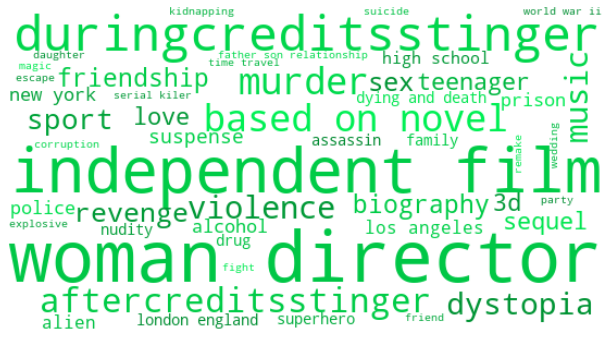

In [112]:
words = dict()
trunc_occurences = keyword_occurences[0:50]
for s in trunc_occurences:
    words[s[0]] = s[1]
tone = 100 # define the color of the words
f, ax = plt.subplots(figsize=(14, 6))
wordcloud = WordCloud(width=550,height=300, background_color='white', 
                      max_words=1628,relative_scaling=0.7,
                      color_func = random_color_func,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

___
## 2. Limpieza
___

### 2.1 Entradas duplicadas

Hasta ahora, sólo mirabamos unas pocas variables e intentábamos representar su contenido para tener una idea de su significado. Por tanto, es ahora cuando empieza realmente la tarea de limpieza.

El primer paso consiste en buscar entradas duplicadas. Como un primer paso, se comprueba si si las hay.

In [19]:
doubled_entries = df_initial[df_initial.id.duplicated()]
doubled_entries.shape

(0, 26)

In [20]:
df_temp = df_initial

Ahora examinamos lasfilas con entradas duplicadas teniendo en cuenta únicamente las variables **movie\_title** y **title\_year**, and **director\_name**:

In [21]:
list_var_duplicates = ['movie_title', 'title_year', 'director_name']

Creamos una lista con las entradas con títulos idénticos:

In [22]:
liste_duplicates = df_temp['movie_title'].map(df_temp['movie_title'].value_counts() > 1)
print("Número de entradas duplicadas: {}".format(
    len(df_temp[liste_duplicates][list_var_duplicates])))

Número de entradas duplicadas: 6


y a continuación examinamos algunos casos. Dado que no hay demasiados valores, es posible hacerlo a simple vista:

In [115]:
df_temp[liste_duplicates][list_var_duplicates].sort_values('movie_title')

,movie_title,title_year,director_name
1359,Batman,1989.0,Tim Burton
4267,Batman,1966.0,Leslie H. Martinson
3647,Out of the Blue,1980.0,Dennis Hopper
3693,Out of the Blue,2006.0,Robert Sarkies
972,The Host,2013.0,Andrew Niccol
2877,The Host,2006.0,Bong Joon-ho


Puede verse que estas películas son únicamente remakes.

In [24]:
df_duplicate_cleaned = df_temp

___
### 2.2 Limpieza de keywords

Las keywords tendrán un papel fundamental en el funcionamiento del sistema. De hecho, las recomendaciones se basaran en la similaridad entre películas. Para medir esas similaridades, se mirarán las películas descritas por las mismas keywords. Por tanto, el contenido de la variable **plot_keywords** debe ser analizado, ya que será muy utilizado.

___
#### 2.2.1 Agrupamiento por lexema

Cogemos las keywords que aparecen en **plot_keywords**. Esta lista se limpia usando NLTK. Finalmente, veremos la ocurrencia de cada keyword.

In [25]:
def keywords_inventory(dataframe, column = 'plot_keywords'):
    """Devuelve un diccionario con las palabras que derivan de cada lexema
    a partir de un DataFrame y la columna de la que se quiere extraer
    
    Args:
        dataframe (pd.DataFrame): DataFrame del que obtener la información.
        column (str, optional): Nombre de la columna. Defaults to 'plot_keywords'.
    
    Returns:
        list: Keywords finales que aparecen
        dict: Relación lexema <-> palabras
        dict: Palabra más corta derivada del lexema
    """
    PS = nltk.stem.PorterStemmer()
    keywords_roots  = dict()  # recoger las palabras de cada lexema
    keywords_select = dict()  # asociacion: lexema <-> keyword
    category_keys = []
    icount = 0
    for s in dataframe[column]:
        if pd.isnull(s): continue
        for t in s.split('|'):
            t = t.lower() ; root = PS.stem(t)
            # Para cada lexema, un set con las palabras que lo usan
            if root in keywords_roots:                
                keywords_roots[root].add(t)
            else:
                keywords_roots[root] = {t}
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    key = k ; min_length = len(k)            
            category_keys.append(key)
            keywords_select[s] = key
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("Número de keywords en la variable: '{}': {}".format(column,len(category_keys)))
    return category_keys, keywords_roots, keywords_select

In [26]:
keywords, keywords_roots, keywords_select = keywords_inventory(df_duplicate_cleaned,
                                                               column = 'plot_keywords')

Número de keywords en la variable: 'plot_keywords': 9474


In [27]:
# Muestra de keywords que aparecen en formas similares
#------------------------------------------------------------
icount = 0
for s in keywords_roots.keys():
    if len(keywords_roots[s]) > 1: 
        icount += 1
        if icount < 15: print(icount, keywords_roots[s], len(keywords_roots[s]))

1 {'alien', 'alienation'} 2
2 {'spy', 'spying'} 2
3 {'vigilantism', 'vigilante'} 2
4 {'terrorism', 'terror'} 2
5 {'flood', 'flooding'} 2
6 {'spider', 'spiders'} 2
7 {'horses', 'horse'} 2
8 {'musical', 'music'} 2
9 {'animation', 'anime', 'animal'} 3
10 {'compass', 'compassion'} 2
11 {'train', 'training'} 2
12 {'sail', 'sailing'} 2
13 {'time travel', 'time traveler'} 2
14 {'orc', 'orcs'} 2


In [28]:
# Reemplazo de keywords por su forma principal
#----------------------------------------------
def df_keywords_replacement(df, replacement_dict, roots = False, column = 'plot_keywords'):
    """Reemplaza las palabras clave de una película por las formas básicas de las mismas.

    Args:
        df (pd.DataFrame): DataFrame que contiene la información de las películas
        replacement_dict (dict): Diccionario con los cambios
        roots (bool, optional): Controla si se obtienen las raices de las palabras de las
        keywords. Defaults to False.
        column (str, optional): Columna en la que realizar la transformación. Defaults to 'plot_keywords'.

    Returns:
        pd.DataFrame: DataFrame con las sustituciones realizadas
    """
    PS = nltk.stem.PorterStemmer()
    df_new = df.copy(deep = True)
    for index, row in df_new.iterrows():
        chain = row[column]
        if pd.isnull(chain): continue
        new_list = []
        for s in chain.split('|'): 
            key = PS.stem(s) if roots else s
            if key in replacement_dict.keys():
                new_list.append(replacement_dict[key])
            else:
                new_list.append(s)       
        df_new.set_value(index, column, '|'.join(new_list)) 
    return df_new

In [137]:
# Reemplazo de keywords por su forma principal
#-------------------------------------------------
df_keywords_cleaned = df_keywords_replacement(df_duplicate_cleaned, keywords_select,
                                               roots = True)

In [138]:
# Conteo de la repetición de cada Keyword
#----------------------------------
keyword_occurences, keywords_count = count_word(df_keywords_cleaned,'plot_keywords',keywords)
keyword_occurences[:5]

[['', 412],
 ['woman director', 324],
 ['independent film', 318],
 ['duringcreditsstinger', 307],
 ['based on novel', 197]]

In [140]:
len(keywords_count)

2121

___
#### 2.2.2 Grupos de *sinónimos*

Limpiamos la lista de keywords en dos pasos. En un primer paso, se suprimer las keywords que aparecen menos de 5 veces y se reemplazan por un sinónimo de mayor frecuencia. En un segundo paso, se suprimen las keywords que aparecen en menos de 3 películas.

In [31]:
# Obtener los sinónimos de la palabra 'keyword'
#--------------------------------------------------------------
def get_synonyms(keyword):
    """Se obtienen los sinónimos sustantivos de una palabra
    
    Args:
        keyword (str): Palabra de la que obtener los sinónimos
    
    Returns:
        list: Lista con los sinónimos
    """

    lemma = set()
    for ss in wordnet.synsets(keyword):
        for w in ss.lemma_names():
            #_______________________________
            #  Obtenemos los sinónimos que son sustantivos
            index = ss.name().find('.')+1
            if ss.name()[index] == 'n': lemma.add(w.lower().replace('_',' '))
    return lemma   

In [32]:
# Ejemplo de una lista de sinónimos dados por NLTK
#---------------------------------------------------
keyword = 'alien'
lemma = get_synonyms(keyword)
for s in lemma:
    print(' "{:<30}" in keywords list -> {} {}'.format(s, s in keywords,
                                                keywords_count[s] if s in keywords else 0 ))

 "unknown                       " in keywords list -> False 0
 "alien                         " in keywords list -> True 80
 "noncitizen                    " in keywords list -> False 0
 "extraterrestrial              " in keywords list -> True 4
 "extraterrestrial being        " in keywords list -> False 0
 "stranger                      " in keywords list -> True 7
 "outlander                     " in keywords list -> False 0
 "foreigner                     " in keywords list -> False 0


In [33]:
# Comprobar si 'word' es una clave con más ocurrecncias que el umbral   
#----------------------------------------------------------------------------------
def test_keyword(word, key_count, threshold):
    """Devuelve si una palabra aparece un número mayor de veces que el umbral señalado

    Args:
        word (str): Palabra a buscar
        key_count (dict): Diccionario con las apariciones de cada keyword
        threshold (int): Umbral

    Returns:
        bool: True si aparece un número mayor de veces
    """
    return (False , True)[key_count.get(word, 0) >= threshold] 

In [34]:
keyword_occurences.sort(key = lambda x:x[1], reverse = False)
key_count = dict()
for s in keyword_occurences:
    key_count[s[0]] = s[1]
#__________________________________________________________________________
# Creación de un diccionario para reemplazar keywords por sinónimos de mayor frecuencia
remplacement_word = dict()
icount = 0
for index, [word, nb_apparitions] in enumerate(keyword_occurences):
    if nb_apparitions > 5: continue  # Sólo las keywords que aparecen menos de 5 veces
    lemma = get_synonyms(word)
    if len(lemma) == 0: continue     #Caso de plurales
    #_________________________________________________________________
    word_list = [(s, key_count[s]) for s in lemma 
                  if test_keyword(s, key_count, key_count[word])]
    word_list.sort(key = lambda x:(x[1],x[0]), reverse = True)    
    if len(word_list) <= 1: continue       # NO se reemplaza
    if word == word_list[0][0]: continue    # Reemplazo por sí mismo
    icount += 1
    if  icount < 8:
        print('{:<12} -> {:<12} (init: {})'.format(word, word_list[0][0], word_list))    
    remplacement_word[word] = word_list[0][0]

print(90*'_'+'\n'+'The replacement concerns {}% of the keywords.'
      .format(round(len(remplacement_word)/len(keywords)*100,2)))

narcism      -> narcissism   (init: [('narcissism', 1), ('narcism', 1)])
apparition   -> shadow       (init: [('shadow', 3), ('phantom', 3), ('apparition', 1)])
macao        -> macau        (init: [('macau', 1), ('macao', 1)])
regent       -> trustee      (init: [('trustee', 1), ('regent', 1)])
civilization -> culture      (init: [('culture', 2), ('civilization', 1)])
ark          -> ark of the covenant (init: [('ark of the covenant', 2), ('ark', 1)])
automaton    -> zombie       (init: [('zombie', 45), ('robot', 27), ('automaton', 1)])
__________________________________________________________________________________________
The replacement concerns 5.96% of the keywords.


In [35]:
# 2 reemplazos sucesivos
#---------------------------
print('Keywords that appear both in keys and values:'.upper()+'\n'+45*'-')
icount = 0
for s in remplacement_word.values():
    if s in remplacement_word.keys():
        icount += 1
        if icount < 10: print('{:<20} -> {:<20}'.format(s, remplacement_word[s]))

for key, value in remplacement_word.items():
    if value in remplacement_word.keys():
        remplacement_word[key] = remplacement_word[value]                    

KEYWORDS THAT APPEAR BOTH IN KEYS AND VALUES:
---------------------------------------------
shadow               -> dark                
failure              -> loser               
leech                -> parasite            
carnival             -> circus              
pit                  -> hell                
drawing              -> lottery             
deal                 -> mountain            
twist                -> crook               
pest                 -> plague              


In [36]:
# Se reemplazan variaciones de una keyword por su keyword principal
#----------------------------------------------------------
df_keywords_synonyms = \
            df_keywords_replacement(df_keywords_cleaned, remplacement_word, roots = False)   
keywords, keywords_roots, keywords_select = \
            keywords_inventory(df_keywords_synonyms, column = 'plot_keywords')

Número de keywords en la variable: 'plot_keywords': 8910


In [37]:
# Nuevo conteo de la ocurrencia de cada keyword
#-------------------------------------
new_keyword_occurences, keywords_count = count_word(df_keywords_synonyms,
                                                    'plot_keywords',keywords)
new_keyword_occurences[:5]

[['', 412],
 ['woman director', 324],
 ['independent film', 318],
 ['duringcreditsstinger', 307],
 ['based on novel', 197]]

In [38]:
# Borrrado de keywords con baja frecuencia
#-------------------------------------------
def replacement_df_low_frequency_keywords(df, keyword_occurences):
    """Modifica las entradas del dataframe, quitando las keywords que aparecen menos 
    de 3 veces.

    Args:
        df (pd.DataFrame): DataFrame de películas
        keyword_occurences ([type]): Diccionario que contiene la ocurrencia de cada keyword

    Returns:
        pd.Dataframe: DataFrame con las nuevas keywords
    """
    df_new = df.copy(deep = True)
    key_count = dict()
    for s in keyword_occurences: 
        key_count[s[0]] = s[1]    
    for index, row in df_new.iterrows():
        chain = row['plot_keywords']
        if pd.isnull(chain): continue
        new_list = []
        for s in chain.split('|'): 
            if key_count.get(s, 4) > 3: new_list.append(s)
        df_new.set_value(index, 'plot_keywords', '|'.join(new_list))
    return df_new  

In [39]:
# Creation of a dataframe where keywords of low frequencies are suppressed
#-------------------------------------------------------------------------
df_keywords_occurence = \
    replacement_df_low_frequency_keywords(df_keywords_synonyms, new_keyword_occurences)
keywords, keywords_roots, keywords_select = \
    keywords_inventory(df_keywords_occurence, column = 'plot_keywords')    

Número de keywords en la variable: 'plot_keywords': 2121


In [40]:
# Nuevo conteo de ocurrencia
#-------------------
new_keyword_occurences, keywords_count = count_word(df_keywords_occurence,
                                                    'plot_keywords',keywords)
new_keyword_occurences[:5]

[['', 508],
 ['woman director', 324],
 ['independent film', 318],
 ['duringcreditsstinger', 307],
 ['based on novel', 197]]

findfont: Font family ['sams-serif'] not found. Falling back to DejaVu Sans.


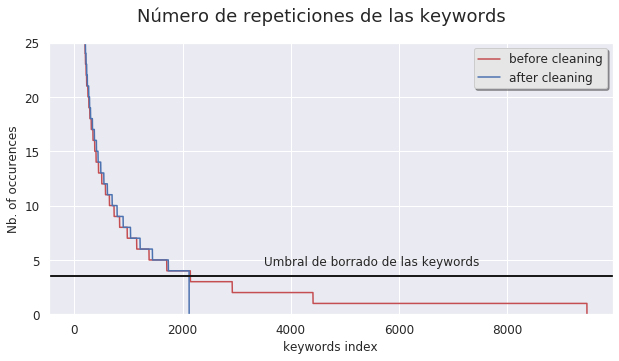

In [81]:
# Gráfico de ocurrencia de las keyword
#----------------------------
font = {'family' : 'sans-serif', 'weight' : 'normal', 'size'   : 12}
mpl.rc('font', **font)

keyword_occurences.sort(key = lambda x:x[1], reverse = True)

y_axis = [i[1] for i in keyword_occurences]
x_axis = [k for k,i in enumerate(keyword_occurences)]

new_y_axis = [i[1] for i in new_keyword_occurences]
new_x_axis = [k for k,i in enumerate(new_keyword_occurences)]

f, ax = plt.subplots(figsize=(9, 5))
ax.plot(x_axis, y_axis, 'r-', label='before cleaning')
ax.plot(new_x_axis, new_y_axis, 'b-', label='after cleaning')

ax.tick_params(axis='both', which='major', labelsize=font['size'])


# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
for label in legend.get_texts():
    label.set_fontsize('medium')
            
plt.ylim((0,25))
plt.axhline(y=3.5, linewidth=2, color = 'k')
plt.xlabel("keywords index", family='sans-serif', fontsize = font['size'])
plt.ylabel("Nb. of occurences", family='sams-serif', fontsize = font['size'])
plt.suptitle("Número de repeticiones de las keywords", fontsize = 18, family='sans-serif')
plt.text(3500, 4.5, 'Umbral de borrado de las keywords', fontsize = font['size'])
plt.show()

___
### 2.3 Correlaciones

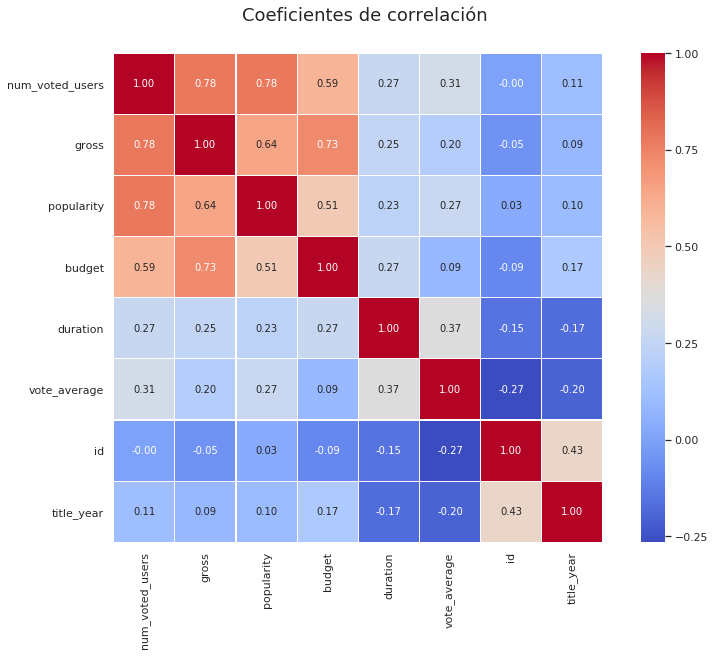

In [82]:
f, ax = plt.subplots(figsize=(12, 9))
#_____________________________
# Cálculo de correlaciones
corrmat = df_keywords_occurence.dropna(how='any').corr()
#________________________________________
k = 17 # number of variables for heatmap
cols = corrmat.nlargest(k, 'num_voted_users')['num_voted_users'].index
cm = np.corrcoef(df_keywords_occurence[cols].dropna(how='any').values.T)
sns.set(font_scale=1)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 10}, linewidth = 0.1, cmap = 'coolwarm',
                 yticklabels=cols.values, xticklabels=cols.values)
f.text(0.5, 0.93, "Coeficientes de correlación", ha='center', fontsize = 18, family='fantasy')
plt.show()

In [43]:
LOST_COLUMNS = [
    'actor_1_facebook_likes',
    'actor_2_facebook_likes',
    'actor_3_facebook_likes',
    'aspect_ratio',
    'cast_total_facebook_likes',
    'color',
    'content_rating',
    'director_facebook_likes',
    'facenumber_in_poster',
    'movie_facebook_likes',
    'movie_imdb_link',
    'num_critic_for_reviews',
    'num_user_for_reviews'
                ]

In [44]:
#__________
# dropping
#dropped_var = ['aspect_ratio', 'budget', 'facenumber_in_poster',
#               'content_rating', 'cast_total_facebook_likes']
#df_var_cleaned = df_keywords_occurence.drop(dropped_var, axis = 1)
#________________
# and reordering
new_col_order = ['movie_title', 'title_year', 'genres', 'plot_keywords', 
                 'director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name',
                 'director_facebook_likes', 'actor_1_facebook_likes', 'actor_2_facebook_likes',
                 'actor_3_facebook_likes', 'movie_facebook_likes', 'num_critic_for_reviews', 
                 'num_user_for_reviews', 'num_voted_users', 'language', 'country',
                 'imdb_score', 'movie_imdb_link', 'color', 'duration', 'gross', ]
new_col_order = [col for col in new_col_order if col not in LOST_COLUMNS]
print(new_col_order)
new_col_order = [IMDB_COLUMNS_TO_REMAP[col] if col in IMDB_COLUMNS_TO_REMAP else col
                 for col in new_col_order]
print(new_col_order)
new_col_order = [TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES[col] if col in TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES else col
                 for col in new_col_order]
print(new_col_order)
df_var_cleaned = df_keywords_occurence[new_col_order]

['movie_title', 'title_year', 'genres', 'plot_keywords', 'director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name', 'num_voted_users', 'language', 'country', 'imdb_score', 'duration', 'gross']
['movie_title', 'title_year', 'genres', 'plot_keywords', 'director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name', 'num_voted_users', 'language', 'country', 'vote_average', 'duration', 'gross']
['movie_title', 'title_year', 'genres', 'plot_keywords', 'director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name', 'num_voted_users', 'language', 'country', 'vote_average', 'duration', 'gross']


In [45]:
set2 = set(list(df_var_cleaned.columns))

In [46]:
set1 = set(list(df_keywords_occurence.columns))
set1.difference(list(df_var_cleaned.columns))

{'budget',
 'homepage',
 'id',
 'original_title',
 'overview',
 'popularity',
 'production_companies',
 'production_countries',
 'release_date',
 'spoken_languages',
 'status',
 'tagline'}

___
###  2.4 Valores faltantes

Examinamos el número de valores faltantes en cada variable y escogemos una metodología para completar el dataset.

In [47]:
missing_df = df_var_cleaned.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['filling_factor'] = (df_var_cleaned.shape[0] 
                                - missing_df['missing_count']) / df_var_cleaned.shape[0] * 100
missing_df = missing_df.sort_values('filling_factor').reset_index(drop = True)
missing_df

,column_name,missing_count,filling_factor
0,country,174,96.377264
1,actor_3_name,93,98.063710
2,language,86,98.209452
3,actor_2_name,63,98.688320
4,actor_1_name,53,98.896523
5,director_name,30,99.375390
6,duration,2,99.958359
7,title_year,1,99.979180
8,movie_title,0,100.000000
9,genres,0,100.000000


Ahora representamos el contenido de esta tabla:

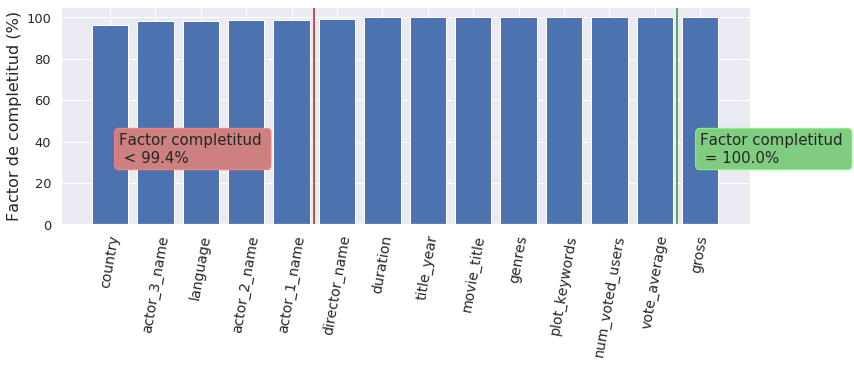

In [88]:
y_axis = missing_df['filling_factor'] 
x_label = missing_df['column_name']
x_axis = missing_df.index

fig = plt.figure(figsize=(11, 4))
plt.xticks(rotation=80, fontsize = 14)
plt.yticks(fontsize = 13)

N_thresh = 5
plt.axvline(x=N_thresh-0.5, linewidth=2, color = 'r')
plt.text(N_thresh-4.8, 30, 'Factor completitud \n < {}%'.format(round(y_axis[N_thresh],1)),
         fontsize = 15, family = 'sans-serif', bbox=dict(boxstyle="round",
                   ec=(1.0, 0.5, 0.5),
                   fc=(0.8, 0.5, 0.5)))
N_thresh = 13
plt.axvline(x=N_thresh-0.5, linewidth=2, color = 'g')
plt.text(N_thresh, 30, 'Factor completitud \n = {}%'.format(round(y_axis[N_thresh],1)),
         fontsize = 15, family = 'sans-serif', bbox=dict(boxstyle="round",
                   ec=(0.5, 1., 0.5),
                   fc=(0.5, 0.8, 0.5)))

plt.xticks(x_axis, x_label,family='sans-serif', fontsize = 14 )
plt.ylabel('Factor de completitud (%)', family='sans-serif', fontsize = 16)
plt.bar(x_axis, y_axis);

___
#### 2.4.1 Completando los años faltantes

Para inferir el año de la película, se usan los actores y el director. Para cada uno de ellos, determinamos el año medio de actividad, utilizando el dataset que tenemos. A continuación, se promedian los valores para determinar el año de la película.

 To infer the title year, I use the list of actors and the director. For each of them, I determine the mean year of activity, using the current dataset. I then average the values obtained to estimate the title year.

In [93]:
df_filling = df_var_cleaned.copy(deep=True)
missing_year_info = df_filling[df_filling['title_year'].isnull()][[
            'director_name','actor_1_name', 'actor_2_name', 'actor_3_name']]
missing_year_info

,director_name,actor_1_name,actor_2_name,actor_3_name
4553,NaN,NaN,NaN,NaN


In [94]:
def fill_year(df):
    """Completa la columna faltante del año teniendo en cuenta la media
    de los periodos de actividad de los actores y el director.
    """
    col = ['director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name']
    usual_year = [0 for _ in range(4)]
    var        = [0 for _ in range(4)]
    #_____________________________________________________________
    # Año medio de actividad para los actores y el director
    for i in range(len(col)):
        usual_year[i] = df.groupby(col[i])['title_year'].mean()
    #_____________________________________________
    # Diccionario que recoja esta información
    actor_year = dict()
    for i in range(4):
        for s in usual_year[i].index:
            if s in actor_year.keys():
                if pd.notnull(usual_year[i][s]) and pd.notnull(actor_year[s]):
                    actor_year[s] = (actor_year[s] + usual_year[i][s])/2
                elif pd.isnull(actor_year[s]):
                    actor_year[s] = usual_year[i][s]
            else:
                actor_year[s] = usual_year[i][s]
        
    #______________________________________
    # Identificación de los años faltantes
    missing_year_info = df[df['title_year'].isnull()]
    #___________________________
    # Completado de los valores faltantes
    icount_replaced = 0
    for index, row in missing_year_info.iterrows():
        value = [ np.NaN for _ in range(4)]
        icount = 0 ; sum_year = 0
        for i in range(4):            
            var[i] = df.loc[index][col[i]]
            if pd.notnull(var[i]): value[i] = actor_year[var[i]]
            if pd.notnull(value[i]): icount += 1 ; sum_year += actor_year[var[i]]
        if icount != 0: sum_year = sum_year / icount 

        if int(sum_year) > 0:
            icount_replaced += 1
            df.set_value(index, 'title_year', int(sum_year))
            if icount_replaced < 10: 
                print("{:<45} -> {:<20}".format(df.loc[index]['movie_title'],int(sum_year)))
    return 

In [95]:
fill_year(df_filling)

#### La comparación de algunas predicciones con valores reales presentan un grado de similaridad relativamente bueno
- Bewitched: **1951** -> en TV  entre 1964 y 1972 
- The A-team: **1977** -> en TV entre 1982 y 1987
- Sleepy Hollow: **2012** -> en TV entre 2013 y 2017

___
#### 2.4.2 Extracción de keywords del título

Como se ha dicho anteriormente, las keywords jugarán un papel fundamental en el funcionamiento del motor de recomendación. Por tanto, se tratará de rellenar los valores faltantes de la variable **plot_keywords** utilizando keywords del título. Para ello, se crea la lista de sinónimos de todas las palabras contenidas en el título y se comprueba si alguna de ellas se encuentra ya en la lista de keywords. En ese caso, se añade esa keyword a la película.

In [96]:
icount = 0
for index, row in df_filling[df_filling['plot_keywords'].isnull()].iterrows():
    icount += 1
    word_list = row['movie_title'].strip().split()
    new_keyword = []
    for s in word_list:
        lemma = get_synonyms(s)
        for t in list(lemma):
            if t in keywords: 
                new_keyword.append(t)                
    if new_keyword and icount < 15: 
        print('{:<50} -> {:<30}'.format(row['movie_title'], str(new_keyword)))
    if new_keyword:
        df_filling.set_value(index, 'plot_keywords', '|'.join(new_keyword)) 

#### 2.4.3 Completando mediante regresionesImputing from regressions

En la sección 2.4 se vio la correlación entre variabels y se encontro que algunas de ellas tenían una cierta correlación, con un coeficiente de Pearson $>0.5$:

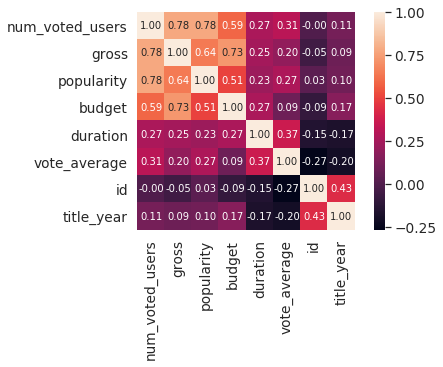

In [97]:
cols = corrmat.nlargest(9, 'num_voted_users')['num_voted_users'].index
cm = np.corrcoef(df_keywords_occurence[cols].dropna(how='any').values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Se usará este hallazgo para completar los valores faltantes de las variables **gross** y **num_voted_users**. Para ello, se realizarán regresiones en parejas de variables correlacionadas:

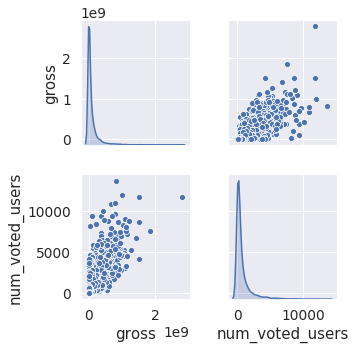

In [98]:
sns.set(font_scale=1.25)
#cols = ['gross', 'num_voted_users', 'num_critic_for_reviews', 'num_user_for_reviews']
cols = ['gross', 'num_voted_users']
sns.pairplot(df_filling.dropna(how='any')[cols],diag_kind='kde', size = 2.5)
plt.show();

En primer lugar, definimos una función que imputa los vbalores faltantes mediante un ajuste lineal de los datos:

In [55]:
def variable_linreg_imputation(df, col_to_predict, ref_col):
    """Completa los valores de la variable col_to_predict haciendo una regresión
    lineal en la que la variable predictora es ref_col.

    Args:
        df (pd.DataFrame): DataFrame de películas
        col_to_predict (str): Variable a predecir
        ref_col (str): Variable con la que predecir

    Returns:
        pd.DataFrame: DataFrame de películas completado
    """
    regr = linear_model.LinearRegression()
    test = df[[col_to_predict,ref_col]].dropna(how='any', axis = 0)
    X = np.array(test[ref_col])
    Y = np.array(test[col_to_predict])
    X = X.reshape(len(X),1)
    Y = Y.reshape(len(Y),1)
    regr.fit(X, Y)

    test = df[df[col_to_predict].isnull() & df[ref_col].notnull()]
    for index, row in test.iterrows():
        value = float(regr.predict(row[ref_col]))
        df.at[index, col_to_predict] =  value
    return df

Esta función toma el dataframe como entrada y los nombres de dos columnas. Se realiza un ajuste lineal entre estas dos columnas y se usa para rellenar los datos faltantes de la primera columna dada:

In [56]:
variable_linreg_imputation(df_filling, 'gross', 'num_voted_users')

,movie_title,title_year,genres,plot_keywords,director_name,actor_1_name,actor_2_name,actor_3_name,num_voted_users,language,country,vote_average,duration,gross
0,Avatar,2009.0,Action|Adventure|Fantasy|Science Fiction,culture clash|future|space colony|society|spac...,James Cameron,Zoe Saldana,Sigourney Weaver,Stephen Lang,11800,English,United States of America,7.2,162.0,2787965087
1,Pirates of the Caribbean: At World's End,2007.0,Adventure|Fantasy|Action,ocean|drug abuse|exotic island|east india trad...,Gore Verbinski,Orlando Bloom,Keira Knightley,Stellan Skarsgård,4500,English,United States of America,6.9,169.0,961000000
2,Spectre,2015.0,Action|Adventure|Crime,spy|based on novel|secret agent|sequel|british...,Sam Mendes,Christoph Waltz,Léa Seydoux,Ralph Fiennes,4466,Français,United Kingdom,6.3,148.0,880674609
3,The Dark Knight Rises,2012.0,Action|Crime|Drama|Thriller,dc comics|crime fighter|terrorist|secret ident...,Christopher Nolan,Michael Caine,Gary Oldman,Anne Hathaway,9106,English,United States of America,7.6,165.0,1084939099
4,John Carter,2012.0,Action|Adventure|Science Fiction,based on novel|mars|medallion|space travel|pri...,Andrew Stanton,Lynn Collins,Samantha Morton,Willem Dafoe,2124,English,United States of America,6.1,132.0,284139100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,El Mariachi,1992.0,Action|Crime|Thriller,united states–mexico barrier|stagecoach|weapon,Robert Rodriguez,Jaime de Hoyos,Peter Marquardt,Reinol Martinez,238,Español,Mexico,6.6,81.0,2040920
4799,Newlyweds,2011.0,Comedy|Romance,,Edward Burns,Kerry Bishé,Marsha Dietlein,Caitlin Fitzgerald,5,NaN,NaN,5.9,85.0,0
4800,"Signed, Sealed, Delivered",2013.0,Comedy|Drama|Romance|TV Movie,date|love at first sight|narration|investigato...,Scott Smith,Kristin Booth,Crystal Lowe,Geoff Gustafson,6,English,United States of America,7.0,120.0,0
4801,Shanghai Calling,2012.0,,,Daniel Hsia,Eliza Coupe,Bill Paxton,Alan Ruck,7,English,United States of America,5.7,98.0,0


Por último, puede verse a cantidad de información faltante aun en el dataframe:

In [57]:
df = df_filling.copy(deep = True)
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['filling_factor'] = (df.shape[0] 
                                - missing_df['missing_count']) / df.shape[0] * 100
missing_df = missing_df.sort_values('filling_factor').reset_index(drop = True)
missing_df

,column_name,missing_count,filling_factor
0,country,174,96.377264
1,actor_3_name,93,98.063710
2,language,86,98.209452
3,actor_2_name,63,98.688320
4,actor_1_name,53,98.896523
5,director_name,30,99.375390
6,duration,2,99.958359
7,title_year,1,99.979180
8,movie_title,0,100.000000
9,genres,0,100.000000


y puede verse que en el peor de los casos el la completitud está alrededor del 96%.

In [58]:
df = df_filling.copy(deep=True)
df.reset_index(inplace = True, drop = True)

___
## 3. MOTOR DE RECOMENDACIÓN

___
### 3.1 Funcionamiento básico del motor
El orden para construir el motor de recomendación tendrá dos pasos básicos:
1. Elegir $N$ películas con un contenido similar a la entrada dada por el usuario
2. Seleccionar las 5 películas mas populares de entre esas $N$ películas

#### 3.1.1 Similaridad

Cuando se construye el motor, el primer paso consiste en definir un criterio que pueda aportar información sobre cómo de parecidas son dos películas. En primer lugar, tenemos en cuenta la descripción de la película seleccionada por el usuario. De ahi tomamos el director, los nombres de los actores y algunas keywords. A partir de estos datos, creamos una matriz en la que cada fila se corresponde con una película de la base de datos y en la que las columnas corresponden con lo dicho anteriormente junto con los *k* generos que se describieron en la sección 1.4
When builing the engine, the first step thus consists in defining a criteria that would tell us how close two films are. To do so, I start from the description of the film that was selected by the user: from it, I get the director name, the names of the actors and a few keywords. I then build a matrix where each row corresponds to a film of the database and where the columns correspond to the previous quantities (director + actors + keywords) plus the *k* genres that were described in section 1.4:


<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg .tg-lboi{border-color:inherit;text-align:left;vertical-align:middle}
.tg .tg-g7sd{font-weight:bold;border-color:inherit;text-align:left;vertical-align:middle}
.tg .tg-fymr{font-weight:bold;border-color:inherit;text-align:left;vertical-align:top}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-g7sd">movie<br>title<br></th>
    <th class="tg-g7sd">director</th>
    <th class="tg-g7sd">actor 1<br></th>
    <th class="tg-g7sd">a2</th>
    <th class="tg-fymr">a3</th>
    <th class="tg-fymr">keyword 1</th>
    <th class="tg-fymr">k2</th>
    <th class="tg-fymr">genre1</th>
    <th class="tg-fymr">g2</th>
    <th class="tg-fymr">...</th>
    <th class="tg-fymr">gk</th>
  </tr>
  <tr>
    <td class="tg-lboi"><br>Film1</td>
    <td class="tg-lboi">$a_{11}$</td>
    <td class="tg-lboi">$a_{12}$</td>
    <td class="tg-lboi"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky">...</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky">...</td>
    <td class="tg-0pky">$a_{1q}$</td>
  </tr>
  <tr>
    <td class="tg-lboi">...</td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
    <td class="tg-lboi"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky">...</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky">...</td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-lboi">Film i </td>
    <td class="tg-lboi">$a_{i1}$</td>
    <td class="tg-lboi">$a_{i2}$</td>
    <td class="tg-lboi"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky">$a_{ij}$</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky">...</td>
    <td class="tg-0pky">$a_{iq}$</td>
  </tr>
  <tr>
    <td class="tg-0pky">...</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky">...</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky">...</td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-0pky">Film p</td>
    <td class="tg-0pky">$a_{p1}$</td>
    <td class="tg-0pky">$a_{p2}$</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky">...</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky">...</td>
    <td class="tg-0pky">$a_{pq}$</td>
  </tr>
</table>

\begin{table}[]
\centering
\begin{tabular}{|l|l|l|l|l|l|l|l|l|l|l|}
\hline
\textbf{\begin{tabular}[c]{@{}l@{}}movie\\ title\end{tabular}} &
  \textbf{director} &
  \textbf{actor 1} &
  \textbf{a2} &
  \textbf{a3} &
  \textbf{keyword 1} &
  \textbf{k2} &
  \textbf{genre1} &
  \textbf{g2} &
  \textbf{...} &
  \textbf{gk} \\ \hline
Film1  & $a_{11}$ & $a_{12}$ &  &  & ...      &  &  &  & ... & $a_{1q}$ \\ \hline
...    &          &          &  &  & ...      &  &  &  & ... &          \\ \hline
Film i & $a_{i1}$ & $a_{i2}$ &  &  & $a_{ij}$ &  &  &  & ... & $a_{iq}$ \\ \hline
...    &          &          &  &  & ...      &  &  &  & ... &          \\ \hline
Film p & $a_{p1}$ & $a_{p2}$ &  &  & ...      &  &  &  & ... & $a_{pq}$ \\ \hline
\end{tabular}
\caption{Matriz generada para el cálculo de la similaridad entre dos películas}
\label{tab:similarity}
\end{table}

En esta matriz, el elemento $a_{ij}$ toma el valor 0 o 1 dependiendo de la correspondencia entre la significancia entre la columna $j$ y el contenido de la película $i$. Por ejemplo, si "keyword1" está en la película $i$, tendremos $a_{ij} = 1$ y $0$ en otro caso. Una vez esta matriz se ha definido, determinamos la distnaica entre dos películas mediante:
\begin{eqnarray}
d_{m, n} = \sqrt{  \sum_{i = 1}^{N} \left( a_{m,i}  - a_{n,i} \right)^2  } 
\end{eqnarray}

En este punto, únicamente tenemos que seleccionar las $N$ películas que son más cercanas a la entrada seleccionada por el usuario.

#### 3.1.2 Popularidad

Atendiendo a la similaridad entre películas, seleccionamos una lista de $N$ películas. En etse punto, seleccionaremos únicamente 5 películas. Para ello, damos una puntuación a cada entrada. Se computa la puntuación de acuerdo a estos tres criterios:
- La puntuación en IMDB
- El número de votos recibidos por la película
- El año de lanzamiento

Los dos primeros serán una medida directa de la popularidad de varias entradas. Para el tercer criterio, se introduce el año de lanzamiento. Se asume que las preferidas por la persona serán en la mayoria de los casos de la misma época.

A continuación, calculamos la puntuación de acuerdo a esta ecuación:


\begin{eqnarray}
\mathrm{score} = IMDB^2 \times \phi_{\sigma_1, c_1} \times  \phi_{\sigma_2, c_2},
\end{eqnarray}

donde $\phi$ es una función gaussiana del tipo

\begin{eqnarray}
\phi_{\sigma, c}(x) \propto \mathrm{exp}\left(-\frac{(x-c)^2}{2 \, \sigma^2}\right).
\end{eqnarray}

Para lo votos, tomamos el máximo número de votos entre las $N$ películas y fijamos $\sigma_1 = c_1 = m$. Para lso años, ponemos $\sigma_1 = 20$ y centramos la gaussiana en el año de la película seleccionada por el usuario. Con las gaussianas, se pone más peso en las entradas con mayor número de votos y en las que el año de salida es cercano al de la película seleccionada por el usuario.

___
### 3.2 Definición de las funciones del motor

In [59]:
gaussian_filter = lambda x,y,sigma: math.exp(-(x-y)**2/(2*sigma**2))

In [60]:
def entry_variables(df, id_entry): 
    """Calcula los valores tomados por las variables director_name, actor_[1,2,3]_name y plot_keywords para la
    película seleccionada por el usuario.

    Args:
        df (pd.DataFrame): DataFrame de películas
        id_entry (int): Id de la entrada seleccionada

    Returns:
        list: Lista que contiene los valores extraidos para la película seleccionada
    """
    
    col_labels = []    
    if pd.notnull(df['director_name'].iloc[id_entry]):
        for s in df['director_name'].iloc[id_entry].split('|'):
            col_labels.append(s)
            
    for i in range(3):
        column = 'actor_NUM_name'.replace('NUM', str(i+1))
        if pd.notnull(df[column].iloc[id_entry]):
            for s in df[column].iloc[id_entry].split('|'):
                col_labels.append(s)
                
    if pd.notnull(df['plot_keywords'].iloc[id_entry]):
        for s in df['plot_keywords'].iloc[id_entry].split('|'):
            col_labels.append(s)
    return col_labels

In [61]:
df.head(2)

,movie_title,title_year,genres,plot_keywords,director_name,actor_1_name,actor_2_name,actor_3_name,num_voted_users,language,country,vote_average,duration,gross
0,Avatar,2009.0,Action|Adventure|Fantasy|Science Fiction,culture clash|future|space colony|society|spac...,James Cameron,Zoe Saldana,Sigourney Weaver,Stephen Lang,11800,English,United States of America,7.2,162.0,2787965087
1,Pirates of the Caribbean: At World's End,2007.0,Adventure|Fantasy|Action,ocean|drug abuse|exotic island|east india trad...,Gore Verbinski,Orlando Bloom,Keira Knightley,Stellan Skarsgård,4500,English,United States of America,6.9,169.0,961000000


In [62]:
def add_variables(df, REF_VAR):
    """Añade al dataframe de películas las columnas dadas en REF_VAR (que serán el 
    director, etc de unapelícula) y las inicializa a 0 o 1 dependiendo de si la 
    película es del mismo director, tiene a ese actor, etc

    Args:
        df (pd.DataFrame): DataFrame de películas
        REF_VAR (list): Salida de aplicar entry_variables sobre el df y una película

    Returns:
        pd.DataFrame: DataFrame con las nuevas películas
    """
    for s in REF_VAR: 
        df[s] = pd.Series([0 for _ in range(len(df))])
    columns = ['genres', 'actor_1_name', 'actor_2_name',
                'actor_3_name', 'director_name', 'plot_keywords']
    for category in columns:
        for index, row in df.iterrows():
            if pd.isnull(row[category]): 
                continue
            for s in row[category].split('|'):
                if s in REF_VAR: df.set_value(index, s, 1)            
    return df

 **Function creating a list of films**: the *recommand()* function create a list of N (= 31) films similar to the film selected by the user.

In [63]:
def recommend(df, id_entry, N = 31):
    """Crea una lista de N películas similares a las seleccionadas por el usuario

    Args:
        df (pd.DataFrame): DataFrame de películas
        id_entry (int): Id de la entrada seleccionada
        N (int, optional): Number of films recommended 
        (take into account that the nearest will be always itself). Defaults to 31.

    Returns:
        list: List of ids of films recommended
    """
    df_copy = df.copy(deep = True)    
    list_genres = set()
    for s in df['genres'].str.split('|').values:
        list_genres = list_genres.union(set(s))    
    #_____________________________________________________
    # Creación de variables adicionales para comprobar la similaridad
    variables = entry_variables(df_copy, id_entry)
    variables += list(list_genres)
    df_new = add_variables(df_copy, variables)
    #____________________________________________________________________________________
    # Determinación de los vecinos más próximos: la distancia se calcula con las nuevas vairables
    X = df_new.as_matrix(variables)
    nbrs = NearestNeighbors(n_neighbors=N, algorithm='auto', metric='euclidean').fit(X)

    distances, indices = nbrs.kneighbors(X)    
    xtest = df_new.iloc[id_entry].as_matrix(variables)
    xtest = xtest.reshape(1, -1)

    distances, indices = nbrs.kneighbors(xtest)

    return indices[0][:]
    

In [64]:
recommend(df, 2)

array([   2,   29,   11, 1234, 1740, 1100,  640,  425, 2675, 1077,   62,
        134,  183, 3336,  469, 1343, 4339, 1542, 3494, 2433, 1615, 2644,
       2444, 1720, 1610, 1586, 3799, 1743, 1713, 4071, 1697])

 **Function extracting some parameters from a list of films**: the *create\_film\_selection()* function extracts some variables of the dataframe given in input and returns this list for a selection of N films. This list is ordered according to criteria established in the *critere\_selection()* function.

In [65]:
def extract_parameters(df, list_films, N = 31):
    """Extrae algunas variables del dataframe dado como entrada y devuelve la lista
    de N películas. Esta lista se ordena de acuerdo al criterio de la función 
    selection_criteria.

    Args:
        df ([type]): DataFrame de películas
        list_films (list): Lista con las n películas recomendadas
        N (int, optional): Number of films recommended. Defaults to 31.

    Returns:
        list: Películas recomendadas
    """
    parametres_films = ['_' for _ in range(N)]
    i = 0
    max_users = -1
    for index in list_films:
        parametres_films[i] = list(df.iloc[index][['movie_title', 'title_year',
                                        'vote_average', 
                                        'num_voted_users']])
        parametres_films[i].append(index)
        max_users = max(max_users, parametres_films[i][4] )
        i += 1
    # The first element is the selected film itself
    title_main = parametres_films[0][0]
    ref_year  = parametres_films[0][1]
    parametres_films.sort(key = lambda x:selection_criteria(title_main, max_users,
                                                            ref_year, 
                                                            title = x[0], 
                                                            year = x[1],
                                                            score = x[2], 
                                                            votes = x[3]), reverse = True)
    
    return parametres_films 

 **Function comparing 2 film titles**: the sequel *sequel()* function compares the 2 titles passed in input and defines if these titles are similar or not.

In [66]:
def sequel(title_1, title_2):   
    """Compara los títulos de dos películas y devuelve si son similares o no

    Args:
        title_1 (str): Primer título
        title_2 (str): Segundo título

    Returns:
        bool: True if the films are sequels. False otherwise.
    """
    #print("$$$$$$$$$$$$$$$$$$$$$$")
    #print(title_1, "|",title_2)
    #print(fuzz.ratio(title_1, title_2) , fuzz.token_set_ratio(title_1, title_2))
    if fuzz.ratio(title_1, title_2) > 50 or fuzz.token_set_ratio(title_1, title_2) > 60:
        return True
    else:
        return False

 **Function giving marks to films**: the *critere\_selection()* function gives a mark to a film depending on its IMDB score,  the title year and the number of users who have voted for this film.

In [67]:
def selection_criteria(title_main, max_users, ref_year, title, year, score, votes):
    """Calcula la puntuación de una película como recomendación de otra en base 
    a la similaridad de su título, la distancia temporal entre ambos lanzamientos
    y el número de votos de la película evaluaday la puntuación de la película.
    Además, la similitud entre títulos se tiene en cuenta para evitar la 
    recomendación de secuelas. Es decir, si dos películas tienen un nombre muy 
    similar, se desechara como recomendación.

    Args:
        title_main (str): Título de la película dada por el usuario
        max_users (int): Máximo número de votos de las N películas
        ref_year (int): Año de lanzamiento de la película dada por el usuario
        title (str): Título de la película a evaluar
        year (int): Año de lanzamiento de la película a evaluar
        score (float): Votación media de la película a evaluar
        votes (int): Votos de la película a evaluar

    Returns:
        float: Mark of the film given
    """
    if pd.notnull(ref_year):
        factor_1 = gaussian_filter(ref_year, year, 20)
    else:
        factor_1 = 1        

    sigma = max_users * 1.0

    if pd.notnull(votes):
        factor_2 = gaussian_filter(votes, max_users, sigma)
    else:
        factor_2 = 0
        
    if sequel(title_main, title):
        mark = 0
        #print(f"Tenemos sequel entre {title_main} y {title}")
    else:
        mark = score * factor_1 * factor_2
    #print(f"'La nota de {title} es: {mark}'")
    return mark

 **Function adding films**: the *add\_to\_selection()* function complete the *film\_selection* list which contains 5 films that will be recommended to the user. The films are selected from the *parametres\_films* list and are taken into account only if the title is different enough from other film titles. 

In [68]:
def add_to_selection(film_selection, parameters_films, N = 31):
    """Completa la lista film_selection que contiene 5 películas que se recomendarán
    al usuario. Las películas son seleccionadas de parameters_list y sólo se tienen
    en cuenta si el título es suficientemente distinto del de otras películas.

    Args:
        film_selection (list): Lista de películas
        parameters_films (list): Lista de parámetros
        N (int, optional): Películas a puntuar. Defaults to 31.
        M (int, optional): Películas a recomendar. Defaults to 5.

    Returns:
        list: films reselected
    """
    film_list = film_selection[:]
    icount = len(film_list)    
    for i in range(N):
        already_in_list = False
        for s in film_selection:
            if s[0] == parameters_films[i][0]: 
                already_in_list = True
            if sequel(parameters_films[i][0], s[0]): 
                already_in_list = True            
        if already_in_list: continue
            
        icount += 1
        if icount <= 5:
            film_list.append(parameters_films[i])
    return film_list

 **Function filtering sequels**: the *remove\_sequels()* function remove sequels from the list if more that two films from a serie are present. The older one is kept.

In [69]:
def remove_sequels(film_selection):
    """Removes sequels from the list of films given

    Args:
        film_selection (list): Lista de películas de la que quitar las secuelas

    Returns:
        list: Lista sin secuelas
    """ 
    removed_from_selection = []
    for i, film_1 in enumerate(film_selection):
        for j, film_2 in enumerate(film_selection):
            if j <= i: continue 
            if sequel(film_1[0], film_2[0]): 
                last_film = film_2[0] if film_1[1] < film_2[1] else film_1[0]
                removed_from_selection.append(last_film)

    film_list = [film for film in film_selection if film[0] not in removed_from_selection]

    return film_list   

**Main function**: create a list of 5 films that will be recommended to the user.

In [70]:
def find_similarities(df, id_entry, del_sequels = True, verbose = False, N = 31):
    """Dado el id de una película busca las 5 mejores recomendaciones.

    Args:
        df (pd.DataFrame): [description]
        id_entry (int): [description]
        del_sequels (bool, optional): Borrar secuelas de las recomendaciones. Defaults to True.
        N (int, optional): Películas a evaluar. Defaults to 31.
        M (int, optional): Películas a recomendar. Defaults to 31.

    Returns:
        list: Selección de películas recomendadas
    """
    if verbose: 
        print(90*'_' + '\n' + "QUERY: films similar to id={} -> '{}'".format(id_entry,
                                df.iloc[id_entry]['movie_title']))
    #____________________________________
    list_films = recommend(df, id_entry, N)
    #__________________________________
    # Crear lista de N películas
    parameters_films = extract_parameters(df, list_films, N)
    #print("&&\n",parameters_films)
    #_______________________________________
    # Seleccionar 5 películas de la  listaSelect 5 films from this list
    film_selection = []
    film_selection = add_to_selection(film_selection, parameters_films, N)
    #print("&&\n",film_selection)
    #__________________________________
    # Borrado de las secuelas
    if del_sequels: film_selection = remove_sequels(film_selection)
    #______________________________________________
    # Añadir nuevas películas a la lista
    #print(film_selection)
    film_selection = add_to_selection(film_selection, parameters_films, N)
    #_____________________________________________
    selection_titles = []
    for i,s in enumerate(film_selection):
        selection_titles.append([s[0].replace(u'\xa0', u''), s[4]])
        if verbose: print("nº{:<2}     -> {:<30}".format(i+1, s[0]))

    return selection_titles

In [71]:
find_similarities(df, 12)

[['Harry Potter and the Chamber of Secrets', 276],
 ['The Hobbit: The Battle of the Five Armies', 19],
 ['X-Men: Days of Future Past', 46],
 ['Thor: The Dark World', 126],
 ['The Amazing Spider-Man 2', 38]]

In [72]:
dum = find_similarities(df, 2890, del_sequels = False, verbose = True)

__________________________________________________________________________________________
QUERY: films similar to id=2890 -> 'Critical Care'
nº1      -> Patch Adams                   
nº2      -> The Jimmy Show                
nº3      -> The Station Agent             
nº4      -> Welcome to the Dollhouse      
nº5      -> In the Company of Men         


___
### 3.3 Making meaningful recommendations

While building the recommendation engine, we are quickly faced to a big issue: the existence of sequels make that some recommendations may seem quite dumb ... As an exemple, somebody who enjoyed *"Pirates of the Caribbean: Dead Man's Chest"* would probably not like to be adviced to watch this: 

In [73]:
df.iloc[12]

movie_title               Pirates of the Caribbean: Dead Man's Chest
title_year                                                      2006
genres                                      Adventure|Fantasy|Action
plot_keywords      witch|fortune teller|slavery|exotic island|mon...
director_name                                         Gore Verbinski
actor_1_name                                           Orlando Bloom
actor_2_name                                         Keira Knightley
actor_3_name                                       Stellan Skarsgård
num_voted_users                                                 5246
language                                                     English
country                                                      Jamaica
vote_average                                                       7
duration                                                         151
gross                                                     1065659812
Name: 12, dtype: object

In [74]:
dum = find_similarities(df, 12, del_sequels = False, verbose = True)

__________________________________________________________________________________________
QUERY: films similar to id=12 -> 'Pirates of the Caribbean: Dead Man's Chest'
nº1      -> Harry Potter and the Chamber of Secrets
nº2      -> The Hobbit: The Battle of the Five Armies
nº3      -> X-Men: Days of Future Past    
nº4      -> Thor: The Dark World          
nº5      -> The Amazing Spider-Man 2      


In [75]:
dum

[['Harry Potter and the Chamber of Secrets', 276],
 ['The Hobbit: The Battle of the Five Armies', 19],
 ['X-Men: Days of Future Past', 46],
 ['Thor: The Dark World', 126],
 ['The Amazing Spider-Man 2', 38]]

Unfortunately, if we build the engine according to the functionalities described in Section 3.1, this is what we are told !!

The origin of that issue is quite easily understood: many blockbusters have sequels that share the same director, actors and keywords ... Most of the time, the fact that sequels exist mean that it was a "fair" box-office success, which is a synonym of a good IMDB score. Usually, there's an inheritence of success among sequels which entail that according to the way the current engine is built, it is quite probable that if the engine matches one film of a serie, it will end recommending various of them. In the previous exemple, we see that the engine recommends the three films of the *"Lord of the ring"* trilogy, as well as *"Thor"* and *"Thor: the dark world"*. Well, I would personnaly not make that kind of recommendations to a friend ... 

Hence, I tried to find a way to prevent that kind of behaviour and I concluded that the quickest way to do it would be to work on the film's titles. To do so, I used the **fuzzywuzzy** package to build the *remove_sequels()* function. This function defines the degree of similarity of two film titles and if too close, the most recent film is removed from the list of recommendations. Using this function on the previous exemple, we end with the following recommendations:

In [76]:
dum = find_similarities(df, 12, del_sequels = True, verbose = True)

__________________________________________________________________________________________
QUERY: films similar to id=12 -> 'Pirates of the Caribbean: Dead Man's Chest'
nº1      -> Harry Potter and the Chamber of Secrets
nº2      -> The Hobbit: The Battle of the Five Armies
nº3      -> X-Men: Days of Future Past    
nº4      -> Thor: The Dark World          
nº5      -> The Amazing Spider-Man 2      


which seems far more reasonable !! 

But, well, nothing is perfect. This way of discarding some recommendations assumes that there is a a continuity in the names of films pertaining to a serie. This is however not always the case:

In [77]:
dum = find_similarities(df, 2, del_sequels = True, verbose = True)

__________________________________________________________________________________________
QUERY: films similar to id=2 -> 'Spectre'
nº1      -> Mission: Impossible - Rogue Nation
nº2      -> Kick-Ass                      
nº3      -> The Hunger Games: Catching Fire
nº4      -> Quantum of Solace             
nº5      -> Skyfall                       


Here, the user selected a film from the James Bond serie, *'Spectre'*, and the engine recommends him two other James Bond films, *'Casino Royale'* and *'Skyfall'*. Well, I guess that people who enjoyed *'Spectre'* will know that there is not a unique film featuring James Bond, and the current recommendation thus looks a bit irrelevant ...

___
### 3.4 Exemple of recommendation: test-case

In [78]:
selection = dict()
for i in range(0, 20, 3):
    selection[i] = find_similarities(df, i, del_sequels = True, verbose = True)

__________________________________________________________________________________________
QUERY: films similar to id=0 -> 'Avatar'
nº1      -> Star Trek Into Darkness       
nº2      -> Pacific Rim                   
nº3      -> Ender's Game                  
nº4      -> Transformers: Dark of the Moon
nº5      -> The Fifth Element             
__________________________________________________________________________________________
QUERY: films similar to id=3 -> 'The Dark Knight Rises'
nº1      -> Prisoners                     
nº2      -> Drive                         
nº3      -> Kick-Ass                      
nº4      -> Batman Begins                 
nº5      -> Training Day                  
__________________________________________________________________________________________
QUERY: films similar to id=6 -> 'Tangled'
nº1      -> Monsters University           
nº2      -> Frozen                        
nº3      -> Rise of the Guardians         
nº4      -> Toy Story 2      

___
## 4. Conclusion: possible improvements and points to adress

Finally a few things were not considered when building the engine and they should deserve some attention:
- the language of the film was not checked: in fact, this could be important to get sure that the films recommended are in the same language than the one choosen by the user
- another point concerns the replacement of the keywords by more frequent synonyms. In some cases, it was shown that the synonyms selected had a different meaning that the original word. Definitely, the whole process might deserve more attention and be improved.
- another improvement could be to create a list of connections between actors to see which are the actors that use to play in similar movies (I started an analysis in that direction in [another notebook](https://www.kaggle.com/fabiendaniel/categorizing-actors)). Hence, rather than only looking at the actors who are in the film selected by the user, we could enlarge this list by a few more people. Something similar could be done also with the directors.
- extend the detections of sequels to films that don't share similar titles (e.g. James Bond serie)

*Thanks a lot for reaching this point of the notebook !! <br>
If you see anything wrong or something that could be improved, please, tell me !!* <br>

**If you found some interest in this notebook, thanks for upvoting !!**